## Importing Libraries

In [182]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import sklearn
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [183]:
datafile = pd.read_csv("co-emissions-by-sector.csv")
datafile.head()

,Year,Buildings,Industry,Land-use change and forestry,Other fuel combustion,Transport,Manufacturing and construction,Fugitive emissions,Electricity and heat
0,1990,0.54548,0.03348,-0.41858,0.06633,1.42697,0.60451,0.00842,2.15979
1,1991,0.55520,0.03274,-0.41858,0.06405,1.39967,0.56695,0.00957,2.17991
2,1992,0.56508,0.03299,-0.41858,0.04737,1.43066,0.51768,0.00946,2.27697
3,1993,0.58559,0.03484,-0.41858,0.04500,1.45419,0.53247,0.01275,2.33552
4,1994,0.57586,0.03631,-0.41871,0.04577,1.50690,0.53489,0.01280,2.36070


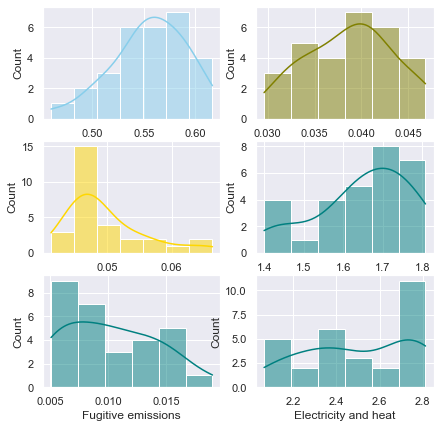

In [184]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(7, 7))

sns.histplot(data=datafile, x="Buildings", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=datafile, x="Industry", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=datafile, x="Other fuel combustion", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=datafile, x="Transport", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=datafile, x="Electricity and heat", kde=True, color="teal", ax=axs[2, 1])
sns.histplot(data=datafile, x="Fugitive emissions", kde=True, color="teal", ax=axs[2, 0])

plt.show()

In [185]:
df1 = datafile[['Year', 'Transport']]
df1.head()
df1.to_csv("Transport.csv")

In [186]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       29 non-null     int64  
 1   Transport  29 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 592.0 bytes


In [187]:
dateparse = lambda x: pd.to_datetime(x, format='%Y', errors = 'coerce')
df = pd.read_csv("Transport.csv", parse_dates=['Year'], index_col='Year', date_parser=dateparse) 
df = df.drop("Unnamed: 0", axis = 1)
df.rename({'Transport': 'CO2'}, axis = 1, inplace=True)
df.head()

,CO2
Year,
1990-01-01,1.42697
1991-01-01,1.39967
1992-01-01,1.43066
1993-01-01,1.45419
1994-01-01,1.50690


<AxesSubplot:xlabel='CO2'>

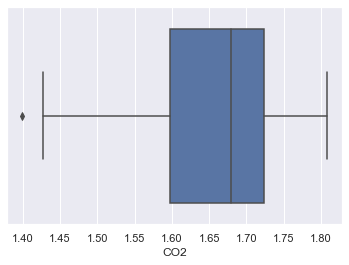

In [188]:
sns.boxplot(df['CO2'])

<AxesSubplot:xlabel='Year'>

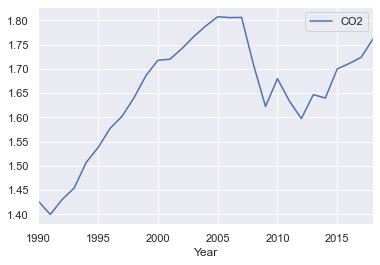

In [189]:
df.plot()

## Transforming data to normal distribution

In [190]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()
    

### Log Transformation

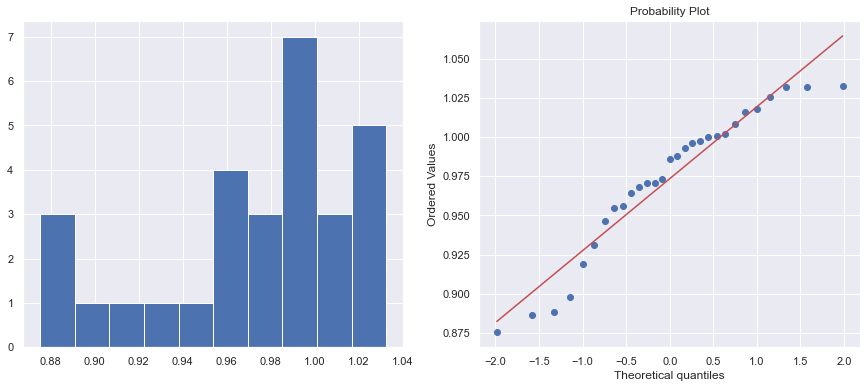

In [191]:
df['Log_co2']=np.log(df['CO2']+1)
diagnostic_plots(df,'Log_co2')

### Reciprocal Transformation

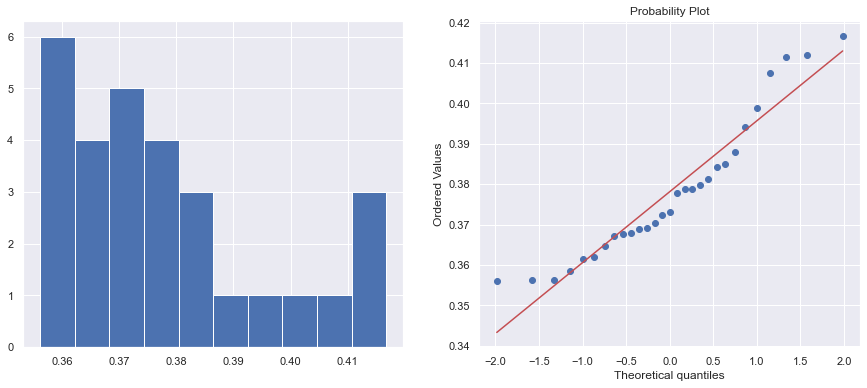

In [192]:
df['Rec_co2']=1/(df['CO2']+1)
diagnostic_plots(df,'Rec_co2')

### Square-Root Transformation

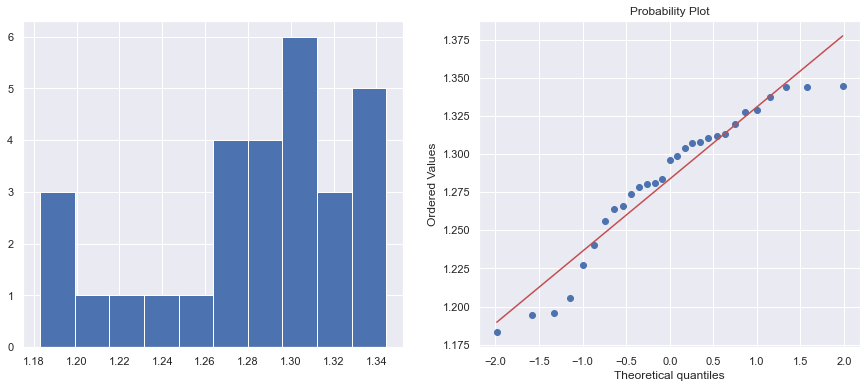

In [193]:
df['sqr_co2']=df['CO2']**(1/2)
diagnostic_plots(df,'sqr_co2')

### Exponential Transformation

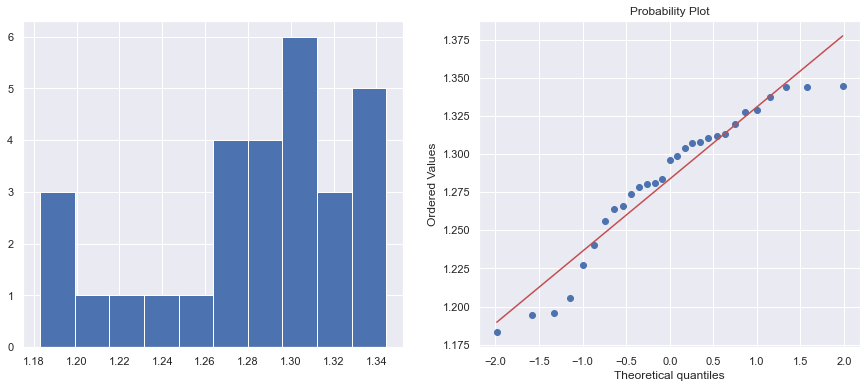

In [194]:
df['Exp_co2']=df['CO2']**(1/5)
diagnostic_plots(df,'sqr_co2')

### Box-cox Transformation

Optimal lambda:  8.312682156092373


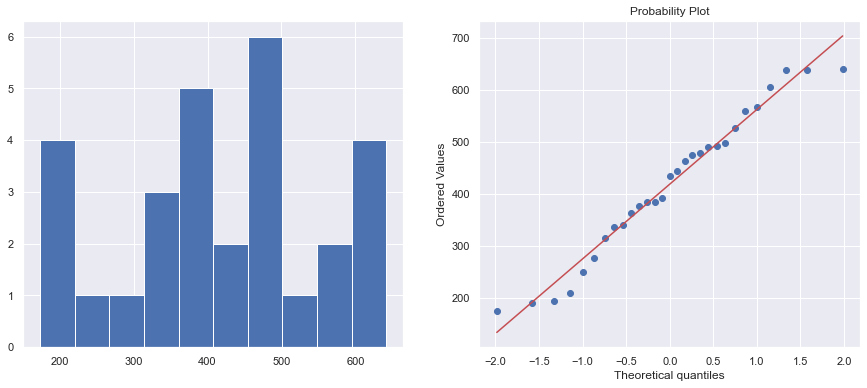

In [195]:
df['co2_boxcox'], param = stats.boxcox(df.CO2+1) # you can vary the exponent as needed

print('Optimal lambda: ', param)

diagnostic_plots(df, 'co2_boxcox')

array([[-1.66081268, -1.66337953,  1.656951  , -1.66081267, -1.6608127 ,
        -1.65697205],
       [-1.78529815, -1.78740444,  1.78163413, -1.78529814, -1.78529818,
        -1.78166218],
       [-1.64315494, -1.64575816,  1.63929501, -1.64315493, -1.64315495,
        -1.63931513],
       [-1.52568996, -1.52838593,  1.52199182, -1.52568995, -1.52568997,
        -1.5220062 ],
       [-1.23000855, -1.23212123,  1.22750585, -1.23000855, -1.23000855,
        -1.22750863],
       [-1.03420058, -1.03556293,  1.03280516, -1.03420058, -1.03420057,
        -1.03280223],
       [-0.75725405, -0.75739121,  0.75749809, -0.75725406, -0.75725404,
        -0.75748941],
       [-0.56545275, -0.56476368,  0.56673967, -0.56545276, -0.56545274,
        -0.56672845],
       [-0.24450485, -0.24268075,  0.24715049, -0.24450486, -0.24450484,
        -0.24713739],
       [ 0.18657321,  0.18910851, -0.18320302,  0.1865732 ,  0.18657322,
         0.18321449],
       [ 0.51656131,  0.51881689, -0.51369057,  0.

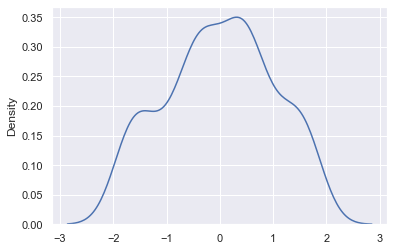

In [196]:

pt = PowerTransformer(method='box-cox')
data = pt.fit_transform(df)
sns.distplot(data, hist=False, kde=True)
data

<AxesSubplot:ylabel='Density'>

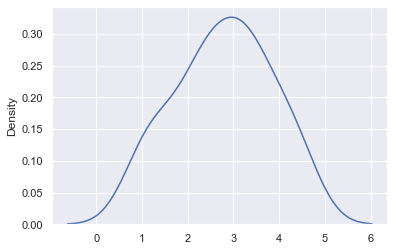

In [197]:

#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(df.CO2) 

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True)

In [198]:
df.dtypes

CO2           float64
Log_co2       float64
Rec_co2       float64
sqr_co2       float64
Exp_co2       float64
co2_boxcox    float64
dtype: object

<AxesSubplot:xlabel='Year'>

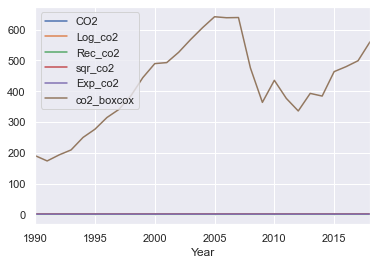

In [199]:
df.plot()

<AxesSubplot:xlabel='Year'>

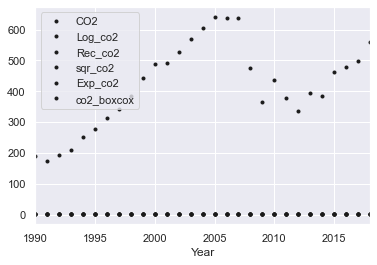

In [200]:
df.plot(style = 'k.')

In [201]:
df.describe()

,CO2,Log_co2,Rec_co2,sqr_co2,Exp_co2,co2_boxcox
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,1.649762,0.973472,0.378154,1.283600,1.104850,418.826242
std,0.119204,0.045712,0.017565,0.047017,0.016322,139.966159
min,1.399670,0.875331,0.356161,1.183076,1.069560,173.794925
25%,1.597530,0.954561,0.367104,1.263934,1.098221,335.902772
50%,1.679770,0.985731,0.373166,1.296059,1.109302,435.288748
75%,1.724020,1.002109,0.384981,1.313019,1.115086,498.791360
max,1.807720,1.032373,0.416724,1.344515,1.125709,641.504914


array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'Log_co2'}>],
       [<AxesSubplot:title={'center':'Rec_co2'}>,
        <AxesSubplot:title={'center':'sqr_co2'}>],
       [<AxesSubplot:title={'center':'Exp_co2'}>,
        <AxesSubplot:title={'center':'co2_boxcox'}>]], dtype=object)

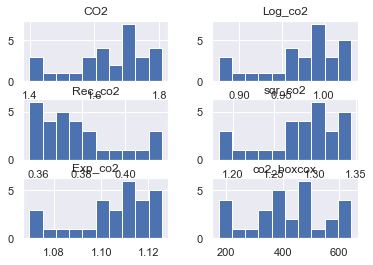

In [202]:
df.hist()

Since we didnot get any conclusive evidence of being normal distribution. We have decided to move on without transforming it to normal distribution.

#### Dropping all transformed values from dataset

In [203]:
df = df.drop(['co2_boxcox', 'Log_co2','Rec_co2','sqr_co2','Exp_co2'], axis = 1)

In [204]:
df.head()

,CO2
Year,
1990-01-01,1.42697
1991-01-01,1.39967
1992-01-01,1.43066
1993-01-01,1.45419
1994-01-01,1.50690


In [205]:
df.dtypes

CO2    float64
dtype: object

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1990-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes


<AxesSubplot:xlabel='Year'>

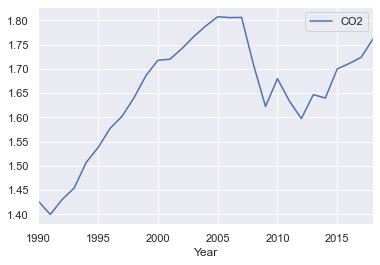

In [207]:
df.plot()

<AxesSubplot:xlabel='Year'>

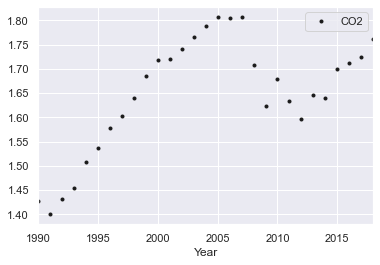

In [208]:
df.plot(style = 'k.')

Preliminary analysis of above plot says that there is presence of clear Level and Trend but we can't say about Seasonality right now.

In [209]:
df.describe()

,CO2
count,29.000000
mean,1.649762
std,0.119204
min,1.399670
25%,1.597530
50%,1.679770
75%,1.724020
max,1.807720


array([[<AxesSubplot:title={'center':'CO2'}>]], dtype=object)

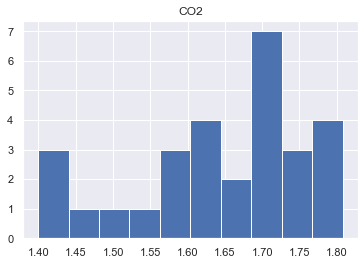

In [210]:
df.hist()

# A) MODEL BUILDING ON STATIONARY DATA

## Test Stationary

Naive test for stationary by checking constant mean and variance

In [211]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1.586307, mean2=1.708987
variance1=0.015405, variance2=0.004880


Since mean and variance changes drastically it is evident that out data is not stationary. Let's confirm it using ADFuller test.

### Testing Stationary using ADFuller test

In [212]:
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 5, center = False).mean()
    rol_std = df.rolling(window = 5, center = False).std()
    
    plt.plot(df, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

In [213]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)
    
    if df_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is non-stationary")
    else:
        print("Failed to accept null hypothesis. Data is stationary ")
        

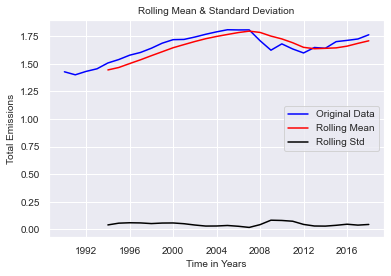

In [214]:
TestStationaryPlot(df)

In [215]:
TestStationaryAdfuller(df)

Test Statistic                 -2.795267
p-value                         0.058953
#Lags Used                      3.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64
Failed to accept null hypothesis. Data is stationary 


THE DATA FOR THIS IS ALREADY STATIONARY\
The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to accept the null hypothesis. Therefore the series is non stationary. 

## Transforming data to Stationary

Transforming data to stationary using three following methods:
- Moving Average
- Differencing
- Decomposing

### 1. Moving Average

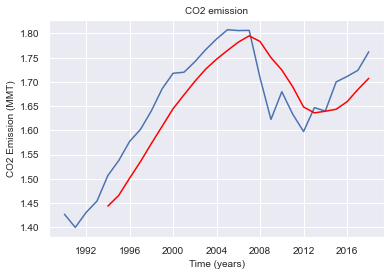

In [216]:
moving_avg = df.rolling(5).mean()
plt.plot(df)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

In [217]:
moving_avg_diff = df - moving_avg
moving_avg_diff.head(13)

,CO2
Year,
1990-01-01,NaN
1991-01-01,NaN
1992-01-01,NaN
1993-01-01,NaN
1994-01-01,0.063222
1995-01-01,0.071924
1996-01-01,0.075850
1997-01-01,0.066496
1998-01-01,0.067492


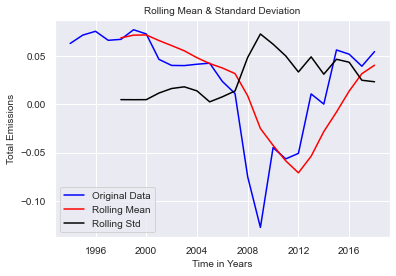

In [218]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

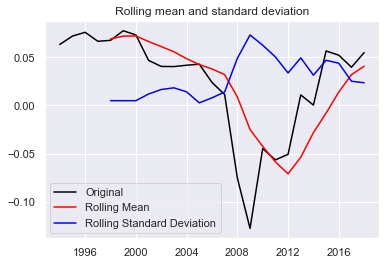

In [219]:
rmean=moving_avg_diff.rolling(window=5).mean()
rstd=moving_avg_diff.rolling(window=5).std()
orig=plt.plot(moving_avg_diff , color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

In [220]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                 -0.545183
p-value                         0.882894
#Lags Used                      8.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64
Failed to accept null hypothesis. Data is stationary 


The rolling mean values appear to be varying slightly. The Test Statistic is smaller than the 10% 5%, and 1% of critical values. So, we can say with 99% confidence level that the dataset is a stationary series.

### 2. Eliminating trend and seasonality: Differencing

One of the most common method of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the original observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done as follows:

#### 2(A) : First order differencing

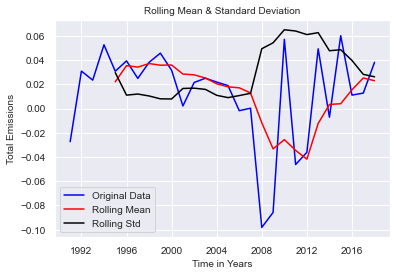

In [221]:
df_first_difference = df - df.shift(1)  
TestStationaryPlot(df_first_difference.dropna(inplace=False))

In [222]:
TestStationaryAdfuller(df_first_difference.dropna(inplace=False))

Test Statistic                 -4.164683
p-value                         0.000756
#Lags Used                      0.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64
Failed to reject null hypothesis. Data is non-stationary


The first difference improves the stationarity of the series significantly. Let us use also the ***seasonal first order difference*** to remove the seasonality of the data and see how that impacts stationarity of the data.

#### 2(B) : Seasonal First order differencing

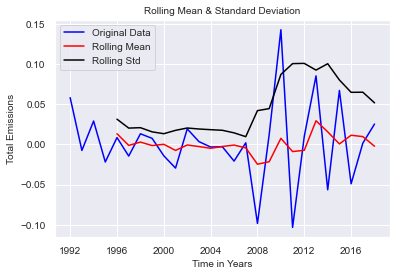

In [223]:
df_seasonal_first_difference = df_first_difference - df_first_difference.shift(1)  
TestStationaryPlot(df_seasonal_first_difference.dropna(inplace=False))

In [224]:
TestStationaryAdfuller(df_seasonal_first_difference.dropna(inplace=False))

Test Statistic                 -3.126217
p-value                         0.024673
#Lags Used                      8.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64
Failed to accept null hypothesis. Data is stationary 


We are considering this seasonal first difference for further analysis because it looks more stationary

### 3. Eliminating trend and seasonality: Decomposing

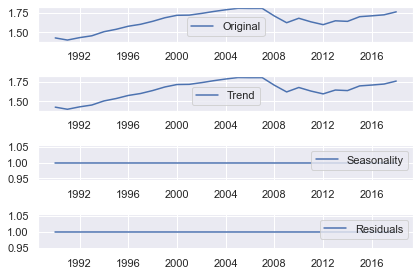

In [225]:
decomposition = seasonal_decompose(df, model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, no seasonaltiy in data and we can model the trend. Here original data and trend both are equal.

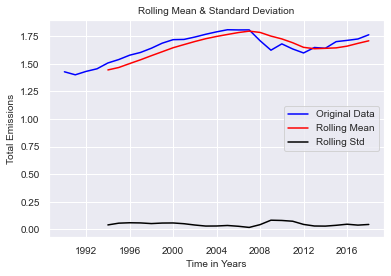

Test Statistic                 -2.795267
p-value                         0.058953
#Lags Used                      3.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64
Failed to accept null hypothesis. Data is stationary 


In [226]:
df_decompose = trend
df_decompose.dropna(inplace=True)
TestStationaryPlot(df_decompose)
TestStationaryAdfuller(df_decompose)

## Plot the ACF and PACF charts and find the optimal parameters

* **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the time series (ts) with a lagged version of itself.
* **Partial Autocorrelation Function (PACF)**: This measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In the next step we will be determing the tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation plots.  The plot below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs inorder to select the parameters. 

### ACF & PACF plot for seasonal first order difference

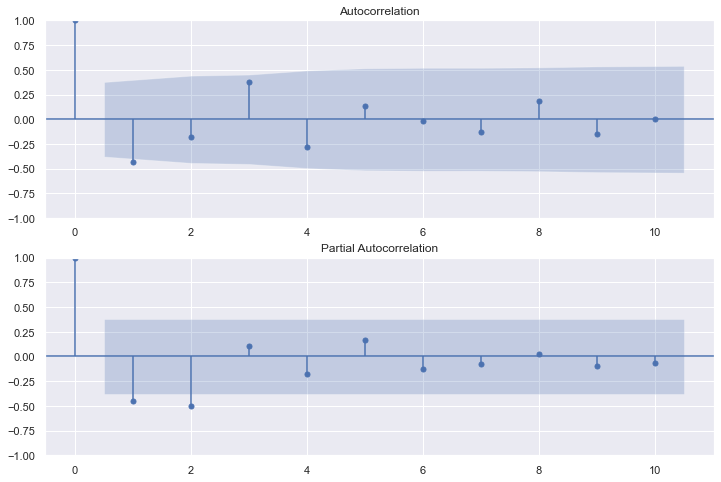

In [227]:
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_first_difference.dropna(inplace=False), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_first_difference.dropna(inplace=False), lags=10, ax=ax2)

We will find optimal parameters (p,d,q) using grid search later

## Data Partitioning

- **Training Data** = Fit the model only to training period
- **Validating Data** = Assess the model performance on validation
- Deploy model by training on whole dataset
- No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [228]:
#using seasonal first order difference
df_seasonal_first_difference.head()

,CO2
Year,
1990-01-01,NaN
1991-01-01,NaN
1992-01-01,0.05829
1993-01-01,-0.00746
1994-01-01,0.02918


In [229]:
X = df_seasonal_first_difference.dropna(inplace=False)

In [230]:
X.head()

,CO2
Year,
1992-01-01,0.05829
1993-01-01,-0.00746
1994-01-01,0.02918
1995-01-01,-0.02185
1996-01-01,0.00857


In [231]:
# Create Training and Test
train = X.iloc[:20]
test = X.iloc[20:]

In [232]:
print(train.shape,test.shape)

(20, 1) (7, 1)


In [233]:
train.head()

,CO2
Year,
1992-01-01,0.05829
1993-01-01,-0.00746
1994-01-01,0.02918
1995-01-01,-0.02185
1996-01-01,0.00857


In [234]:
test.head()

,CO2
Year,
2012-01-01,0.01012
2013-01-01,0.08547
2014-01-01,-0.05650
2015-01-01,0.06729
2016-01-01,-0.04903


### Hyper-parameter Tuning : Finding out optimal (p,d,q)

In [235]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [236]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [237]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.052
ARIMA(0, 0, 1) RMSE=0.044
ARIMA(0, 0, 2) RMSE=0.046
ARIMA(0, 1, 0) RMSE=0.101
ARIMA(0, 1, 1) RMSE=0.052
ARIMA(0, 1, 2) RMSE=0.052
ARIMA(0, 2, 0) RMSE=0.219
ARIMA(0, 2, 1) RMSE=0.104
ARIMA(0, 2, 2) RMSE=0.056
ARIMA(1, 0, 0) RMSE=0.045
ARIMA(1, 0, 1) RMSE=0.045
ARIMA(1, 0, 2) RMSE=0.043
ARIMA(1, 1, 0) RMSE=0.078
ARIMA(1, 1, 1) RMSE=0.045
ARIMA(1, 1, 2) RMSE=0.057
ARIMA(1, 2, 0) RMSE=0.155
ARIMA(1, 2, 1) RMSE=0.079
ARIMA(1, 2, 2) RMSE=0.093
ARIMA(2, 0, 0) RMSE=0.045
ARIMA(2, 0, 1) RMSE=0.052
ARIMA(2, 0, 2) RMSE=0.048
ARIMA(2, 1, 0) RMSE=0.049
ARIMA(2, 1, 1) RMSE=0.050
ARIMA(2, 1, 2) RMSE=0.053
ARIMA(2, 2, 0) RMSE=0.077
ARIMA(2, 2, 1) RMSE=0.050
ARIMA(2, 2, 2) RMSE=0.057
ARIMA(3, 0, 0) RMSE=0.049
ARIMA(3, 0, 1) RMSE=0.045
ARIMA(3, 0, 2) RMSE=0.043
ARIMA(3, 1, 0) RMSE=0.052
ARIMA(3, 1, 1) RMSE=0.050
ARIMA(3, 1, 2) RMSE=0.047
ARIMA(3, 2, 0) RMSE=0.083
ARIMA(3, 2, 1) RMSE=0.053
ARIMA(3, 2, 2) RMSE=0.064
ARIMA(4, 0, 0) RMSE=0.051
ARIMA(4, 0, 1) RMSE=0.049
ARIMA(4, 0, 

## ARIMA model

In [238]:
# 1,0,2
model_arima = ARIMA(train['CO2'],order = (1,0,2))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  36.319
Date:                Sun, 10 Apr 2022   AIC                            -62.638
Time:                        18:06:38   BIC                            -57.659
Sample:                    01-01-1992   HQIC                           -61.666
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.948      0.051      -0.006    1.89e-05
ar.L1         -0.5491      1.068     -0.514      0.607      -2.641       1.543
ma.L1         -0.2247      6.207     -0.036      0.971     -12.390      11.940
ma.L2         -0.7604      3.839     -0.198      0.843      -8.284       6.764
sigma2         0.0013      0.008      0.170      0.865      -0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.21
Prob(Q):                              0.84   Prob(JB):                         0.12
Heteroskedasticity (H):               2.76   Skew:                            -0.91
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [239]:
### make prediction on test set
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2012-01-01    0.002795
2013-01-01    0.024539
2014-01-01   -0.018298
2015-01-01    0.005224
2016-01-01   -0.007692
2017-01-01   -0.000600
2018-01-01   -0.004494
Freq: AS-JAN, Name: predicted_mean, dtype: float64


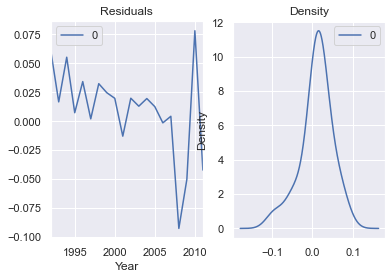

In [240]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [241]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [242]:
stationary_arima_acc = forecast_accuracy(pred_arima.values, test.values)
stationary_arima_acc

{'mape': 1.7287171319149661,
 'me': -0.011846399850862221,
 'mae': 0.04383612796965884,
 'mpe': -0.9777179452154916,
 'rmse': 0.05236784901349657}

## Auto Regressor (AR) model

In [243]:
model_ar = AutoReg(train,lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   20
Model:                     AutoReg(6)   Log Likelihood                  27.258
Method:               Conditional MLE   S.D. of innovations              0.035
Date:                Sun, 10 Apr 2022   AIC                            -38.515
Time:                        18:06:39   BIC                            -33.403
Sample:                    01-01-1998   HQIC                           -38.988
                         - 01-01-2011                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0179      0.012     -1.526      0.127      -0.041       0.005
CO2.L1        -0.4772      0.276     -1.729      0.084      -1.018       0.064
CO2.L2        -1.3177      0.356     -3.702      0.0

In [244]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2012-01-01   -0.129747
2013-01-01    0.181467
2014-01-01    0.001010
2015-01-01   -0.232501
2016-01-01    0.171452
2017-01-01    0.141465
2018-01-01   -0.352998
Freq: AS-JAN, dtype: float64


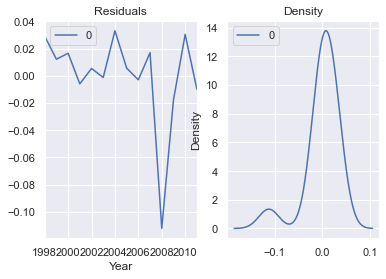

In [245]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [246]:
stationary_ar_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_ar_acc

{'mape': 20.27920395885979,
 'me': -0.04346456717311172,
 'mae': 0.1787722380555223,
 'mpe': -4.320736292035655,
 'rmse': 0.20747456055501823}

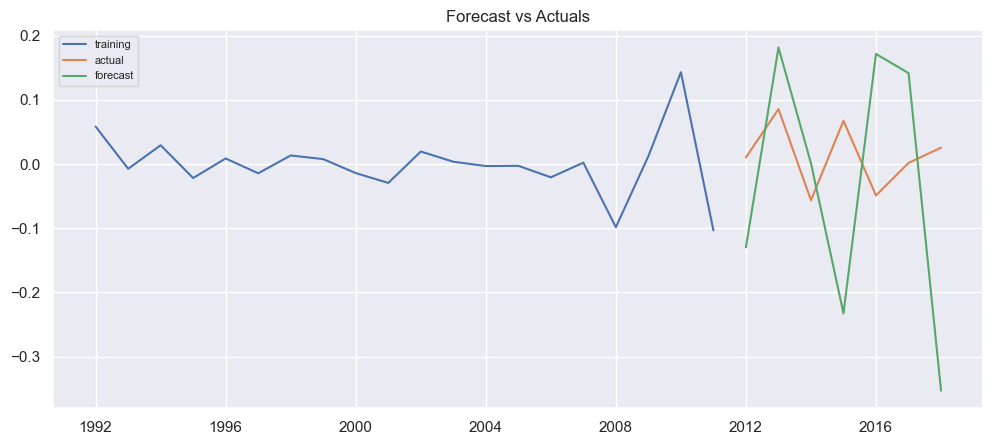

In [247]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Moving Average (MA) model

In [248]:
# only use q or MA parameter
#MA(3)
model_ma = ARIMA(train['CO2'],order = (0,1,3))
model_ma = model_ma.fit()
model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(0, 1, 3)   Log Likelihood                  31.664
Date:                Sun, 10 Apr 2022   AIC                            -55.329
Time:                        18:06:40   BIC                            -51.551
Sample:                    01-01-1992   HQIC                           -54.689
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5726     13.444     -0.117      0.907     -27.922      24.777
ma.L2          0.4506      9.994      0.045      0.964     -19.138      20.039
ma.L3          0.2863      4.901      0.058      0.953      -9.320       9.892
sigma2         0.0015      0.023      0.067      0.947      -0.044       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                35.01
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               6.04   Skew:                             1.77
Prob(H) (two-sided):                  0.05   Kurtosis:                         8.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [249]:
pred_ma = model_ma.predict(start=start,end=end)
print(pred_ma)

2012-01-01   -0.026233
2013-01-01   -0.000905
2014-01-01   -0.006635
2015-01-01   -0.006635
2016-01-01   -0.006635
2017-01-01   -0.006635
2018-01-01   -0.006635
Freq: AS-JAN, Name: predicted_mean, dtype: float64


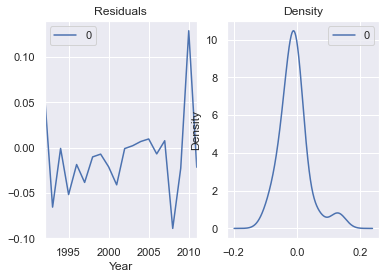

In [250]:
# Plot residual errors
residuals = pd.DataFrame(model_ma.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [251]:
stationary_ma_acc = forecast_accuracy(pred_ma.values, test.values)
stationary_ma_acc

{'mape': 1.910979459635118,
 'me': -0.020673159281124807,
 'mae': 0.045901149895992345,
 'mpe': -1.910979459635118,
 'rmse': 0.05417429976889357}

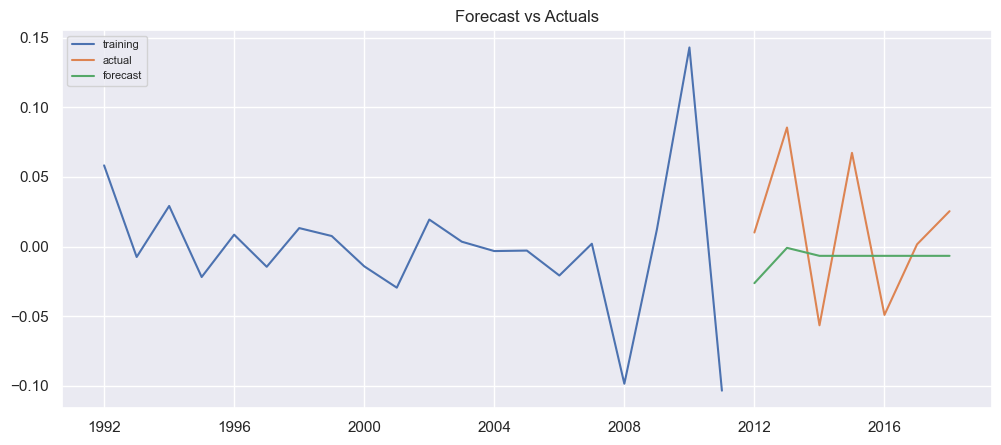

In [252]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ma, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto ARIMA model

In [253]:
model = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-61.813, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-63.104, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-66.497, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-64.505, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-64.510, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-63.070, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.428 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  35.249
Date:                Sun, 10 Apr 2022   AIC                            -66.497
Time:                        18:06:41   BIC                            -64.506
Sample:                           

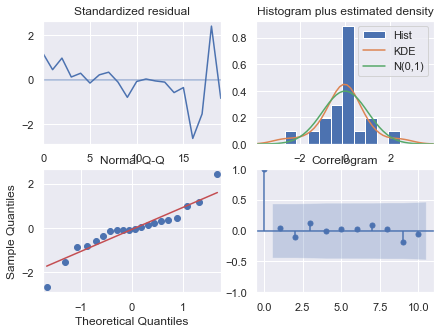

In [254]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [256]:
pred = pd.DataFrame(model.predict(n_periods=7),index=test.index)
pred.columns=['predicted_emission']
print(pred)

            predicted_emission
Year                          
2012-01-01            0.024035
2013-01-01            0.000000
2014-01-01            0.000000
2015-01-01            0.000000
2016-01-01            0.000000
2017-01-01            0.000000
2018-01-01            0.000000


In [257]:
pred = model.predict(start=start,end=end)
print(pred)

[0.02403469 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [258]:
stationary_aa_acc = forecast_accuracy(pred, test.values)
stationary_aa_acc

{'mape': 1.177884059642068,
 'me': -0.009653673896013763,
 'mae': 0.04221620985158992,
 'mpe': -0.7458789830803001,
 'rmse': 0.05096099972760579}

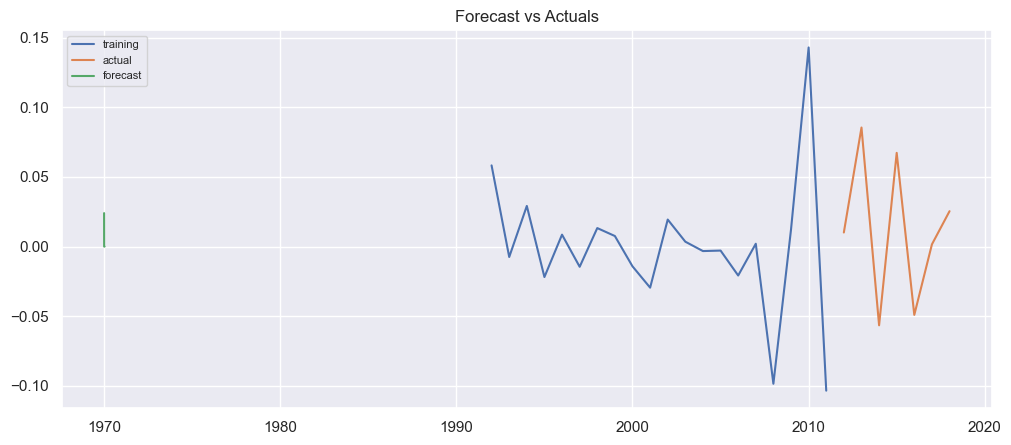

In [259]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [260]:
data = {"MODEL":pd.Series(["ARIMA","Auto Regressor","Moving Average","Auto ARIMA"]),"RMSE_Values":pd.Series([stationary_arima_acc["rmse"],stationary_ar_acc["rmse"],
stationary_ma_acc["rmse"],stationary_aa_acc["rmse"]]),"MAPE_values":pd.Series([stationary_arima_acc["mape"],stationary_ar_acc["mape"],stationary_ma_acc["mape"],stationary_aa_acc["mape"]]),
"ME_values":pd.Series([stationary_arima_acc["me"],stationary_ar_acc["me"],stationary_ma_acc["me"],stationary_aa_acc["me"]]),
"MAE_values":pd.Series([stationary_arima_acc["mae"],stationary_ar_acc["mae"],stationary_ma_acc["mae"],stationary_aa_acc["mae"]]),
        "MPE_values":pd.Series([stationary_arima_acc["mpe"],stationary_ar_acc["mpe"],stationary_ma_acc["mpe"],stationary_aa_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_values,ME_values,MAE_values,MPE_values
3,Auto ARIMA,0.050961,1.177884,-0.009654,0.042216,-0.745879
0,ARIMA,0.052368,1.728717,-0.011846,0.043836,-0.977718
2,Moving Average,0.054174,1.910979,-0.020673,0.045901,-1.910979
1,Auto Regressor,0.207475,20.279204,-0.043465,0.178772,-4.320736


# B) MODEL BUILDING ON NON-STATIONARY DATA / ORIGINAL DATA

In [261]:
df.head()

,CO2
Year,
1990-01-01,1.42697
1991-01-01,1.39967
1992-01-01,1.43066
1993-01-01,1.45419
1994-01-01,1.50690


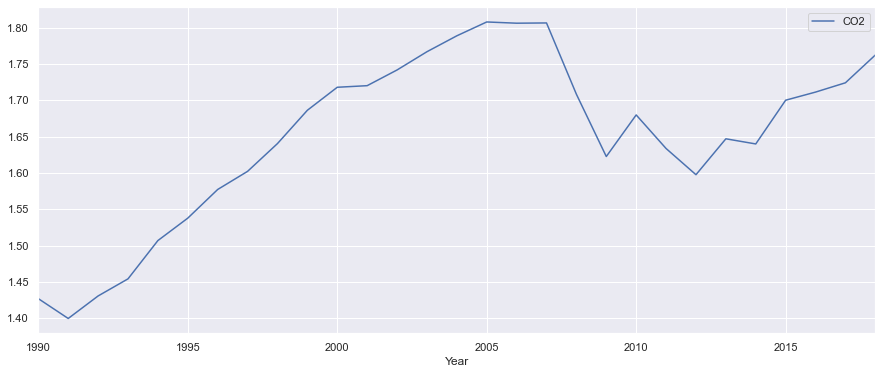

In [262]:
df.plot(figsize=(15, 6))
plt.show()

## Data Partitioning

In [263]:
train = df[:20]
test = df[20:]
print(train.shape,test.shape)

(20, 1) (9, 1)


In [264]:
train.head()

,CO2
Year,
1990-01-01,1.42697
1991-01-01,1.39967
1992-01-01,1.43066
1993-01-01,1.45419
1994-01-01,1.50690


In [265]:
test.head()

,CO2
Year,
2010-01-01,1.67977
2011-01-01,1.63359
2012-01-01,1.59753
2013-01-01,1.64694
2014-01-01,1.63985


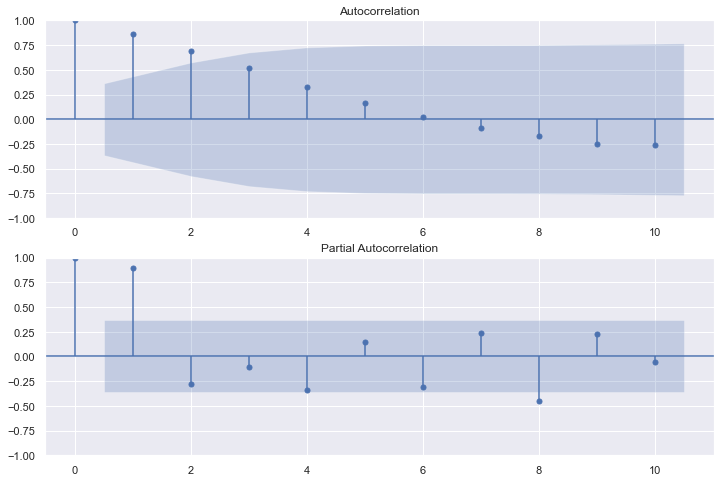

In [266]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=10, ax=ax2)

### Hyper-parameter Tuning : Finding out optimal (p,d,q)


In [267]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [268]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [269]:
# evaluate parameters
p_values = [0,1,2,3,4,5]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.060
ARIMA(0, 0, 1) RMSE=0.044
ARIMA(0, 0, 2) RMSE=0.068
ARIMA(0, 0, 3) RMSE=0.070
ARIMA(0, 0, 4) RMSE=0.074
ARIMA(0, 1, 0) RMSE=0.040
ARIMA(0, 1, 1) RMSE=0.052
ARIMA(0, 1, 2) RMSE=0.066
ARIMA(0, 1, 3) RMSE=0.062
ARIMA(0, 1, 4) RMSE=0.076
ARIMA(0, 2, 0) RMSE=0.074
ARIMA(0, 2, 1) RMSE=0.060
ARIMA(0, 2, 2) RMSE=0.076
ARIMA(0, 2, 3) RMSE=0.073
ARIMA(0, 2, 4) RMSE=0.080
ARIMA(0, 3, 0) RMSE=0.128
ARIMA(0, 3, 1) RMSE=0.078
ARIMA(0, 3, 2) RMSE=0.094
ARIMA(0, 3, 3) RMSE=0.086
ARIMA(0, 3, 4) RMSE=0.076
ARIMA(0, 4, 0) RMSE=0.230
ARIMA(0, 4, 1) RMSE=0.136
ARIMA(0, 4, 2) RMSE=0.085
ARIMA(0, 4, 3) RMSE=0.119
ARIMA(1, 0, 0) RMSE=0.042
ARIMA(1, 0, 1) RMSE=0.053
ARIMA(1, 0, 2) RMSE=0.066
ARIMA(1, 0, 3) RMSE=0.062
ARIMA(1, 0, 4) RMSE=0.072
ARIMA(1, 1, 0) RMSE=0.057
ARIMA(1, 1, 1) RMSE=0.061
ARIMA(1, 1, 2) RMSE=0.068
ARIMA(1, 1, 3) RMSE=0.063
ARIMA(1, 1, 4) RMSE=0.068
ARIMA(1, 2, 0) RMSE=0.069
ARIMA(1, 2, 1) RMSE=0.070
ARIMA(1, 2, 2) RMSE=0.082
ARIMA(1, 2, 3) RMSE=0.087
ARIMA(1, 2, 

## ARIMA

In [356]:
model_arima = ARIMA(train['CO2'],order = (0,1,0))
model_arima = model_arima.fit()
model_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  33.816
Date:                Sun, 10 Apr 2022   AIC                            -65.632
Time:                        18:14:28   BIC                            -64.687
Sample:                    01-01-1990   HQIC                           -65.472
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0017      0.001      3.227      0.001       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   6.29   Jarque-Bera (JB):                12.54
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                            -1.72
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [357]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2010-01-01    1.62255
2011-01-01    1.62255
2012-01-01    1.62255
2013-01-01    1.62255
2014-01-01    1.62255
2015-01-01    1.62255
2016-01-01    1.62255
2017-01-01    1.62255
2018-01-01    1.62255
Freq: AS-JAN, Name: predicted_mean, dtype: float64


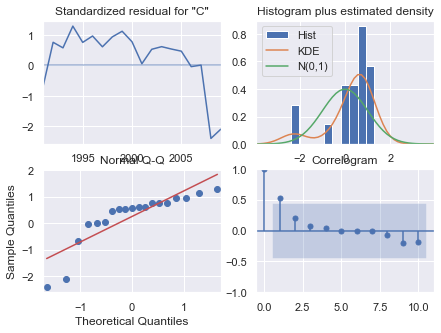

In [358]:
model_arima.plot_diagnostics(figsize=(7,5))
plt.show()

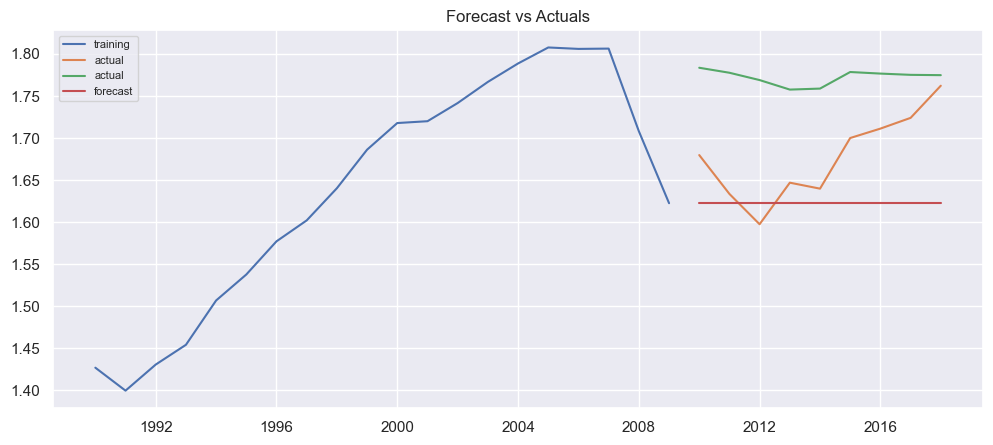

In [359]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [360]:
ns_arima_acc = forecast_accuracy(pred_arima,test.CO2)
ns_arima_acc

{'mape': 0.03526353318327216,
 'me': -0.05469555555555564,
 'mae': 0.06025555555555565,
 'mpe': -0.0317831603577227,
 'rmse': 0.0734803438569346}

## Auto ARIMA

In [361]:
model_auto = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-70.427, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-69.565, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-69.210, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-72.226, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-68.797, Time=0.12 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.370 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  37.113
Date:                Sun, 10 Apr 2022   AIC                            -72.226
Time:                        18:14:30   BIC                            -71.336
Sample:                             0   HQIC                           -72.103
                                 - 20                                         
Co

In [362]:
pred_auto_arima = model_auto.predict(start=start,end=end)
print(pred_auto_arima)

[1.53683    1.45111    1.36539    1.27966999 1.19394999 1.10822999
 1.02250999 0.93678999 0.85106999 0.76534998]


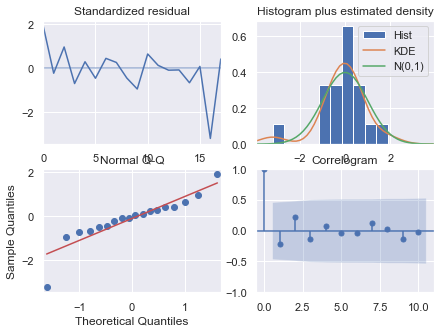

In [363]:
model_auto.plot_diagnostics(figsize=(7,5))
plt.show()

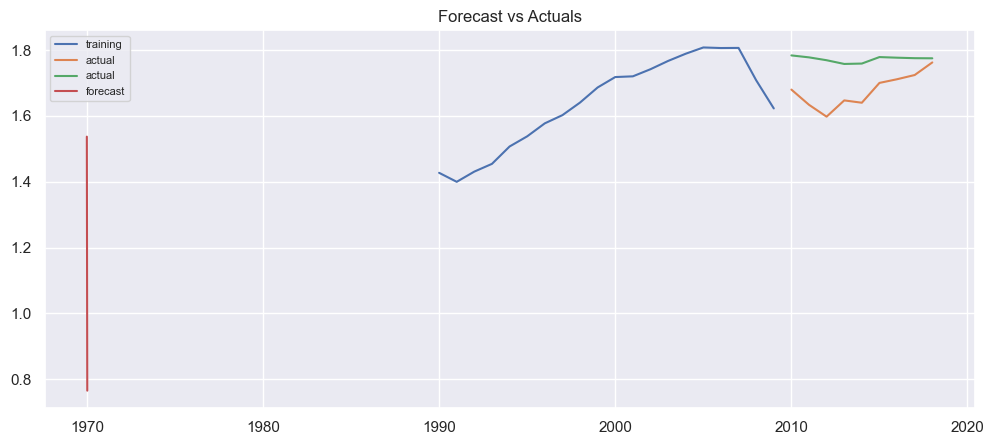

In [364]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_auto_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto Regressor 

In [365]:
model_ar = AutoReg(train,lags = 1).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   20
Model:                     AutoReg(1)   Log Likelihood                  35.797
Method:               Conditional MLE   S.D. of innovations              0.037
Date:                Sun, 10 Apr 2022   AIC                            -65.595
Time:                        18:14:31   BIC                            -62.762
Sample:                    01-01-1991   HQIC                           -65.115
                         - 01-01-2009                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1804      0.100      1.805      0.071      -0.015       0.376
CO2.L1         0.8962      0.061     14.746      0.000       0.777       1.015
                                    Roots           

In [366]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2010-01-01    1.634466
2011-01-01    1.645145
2012-01-01    1.654715
2013-01-01    1.663292
2014-01-01    1.670978
2015-01-01    1.677866
2016-01-01    1.684040
2017-01-01    1.689572
2018-01-01    1.694530
Freq: AS-JAN, dtype: float64


In [368]:
pred_ar

2010-01-01    1.634466
2011-01-01    1.645145
2012-01-01    1.654715
2013-01-01    1.663292
2014-01-01    1.670978
2015-01-01    1.677866
2016-01-01    1.684040
2017-01-01    1.689572
2018-01-01    1.694530
Freq: AS-JAN, dtype: float64

In [367]:
ns_ar_acc = forecast_accuracy(pred_ar.values, test.values)
ns_ar_acc

ValueError: operands could not be broadcast together with shapes (9,) (9,2) 

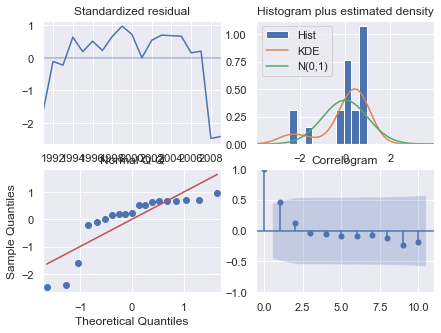

In [369]:
model_ar.plot_diagnostics(figsize=(7,5))
plt.show()

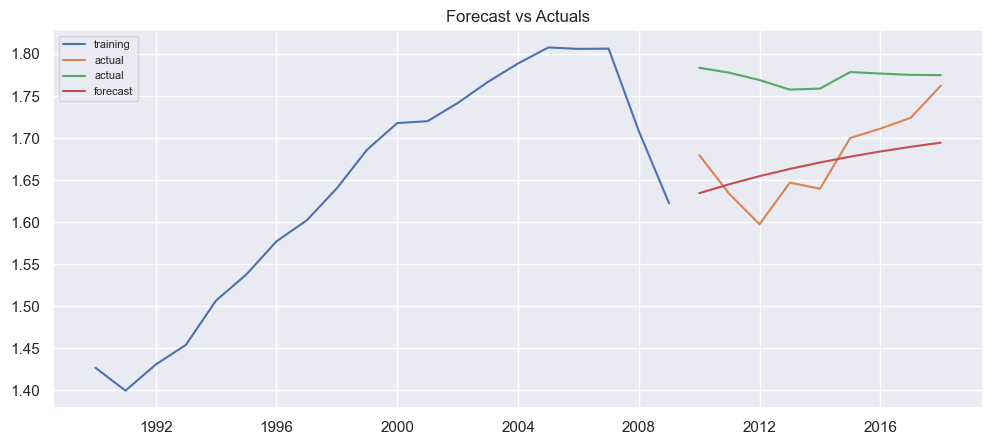

In [370]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Single Exponential Smoothing

In [371]:
fit1 = SimpleExpSmoothing(train).fit(smoothing_level = 0.2,optimized = False)
fit2 =SimpleExpSmoothing(train).fit(smoothing_level = 0.8,optimized = False)

Text(0.5, 1.0, 'Fitted values Vs Original Values')

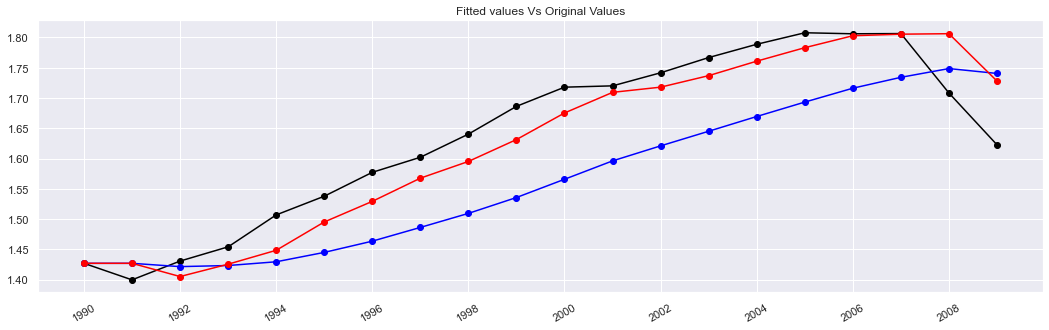

In [372]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [373]:
pred_ses = fit1.predict(start = len(train),end = len(train)+len(test)-1)

In [374]:
ns_ses_acc = forecast_accuracy(pred_ses,test.CO2)
ns_ses_acc

{'mape': 0.031160767537108572,
 'me': 0.039676864811255395,
 'mae': 0.05132467798156166,
 'mpe': 0.024531262370049173,
 'rmse': 0.06310317533257029}

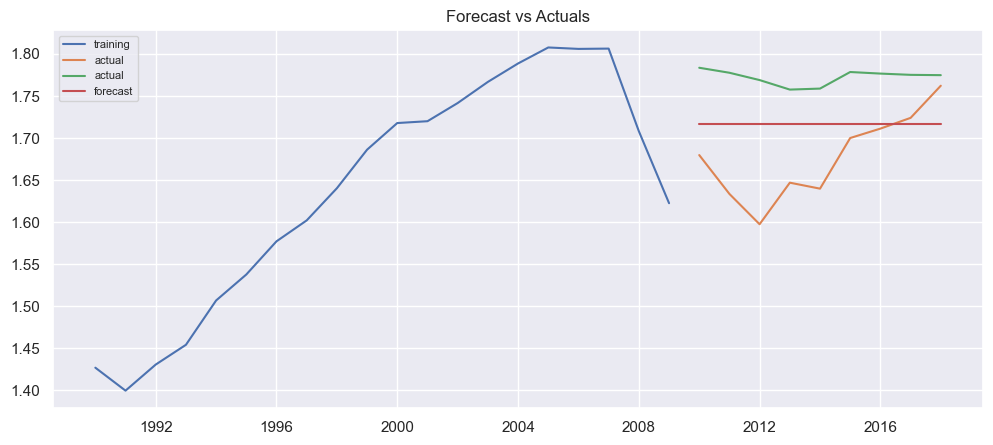

In [375]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Double Exponential Smoothing or Holt's method

In [376]:
#fit1 = Holt(train1).fit()
fit3 = Holt(train,exponential=True,damped_trend=False).fit()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

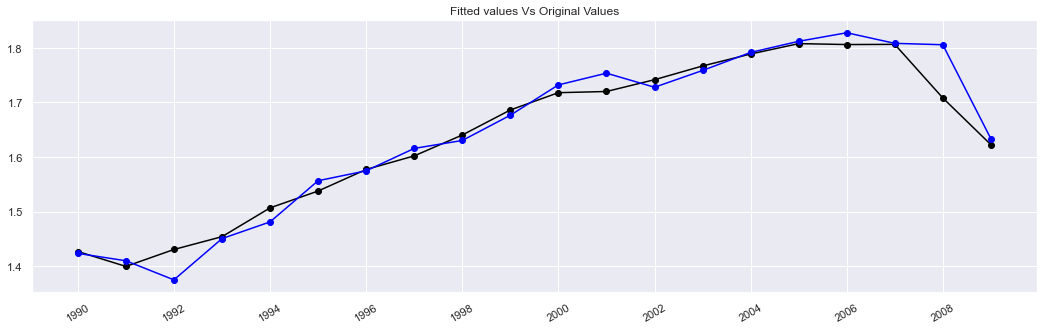

In [377]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit3.fittedvalues,marker = 'o',color = 'blue')
#plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [378]:
pred_holt = fit3.predict(start = len(train),end = len(train)+len(test)-1)

In [379]:
ns_des_acc = forecast_accuracy(pred_holt,test.CO2)
ns_des_acc

{'mape': 0.25248601953159777,
 'me': -0.4283047904818537,
 'mae': 0.4283047904818537,
 'mpe': -0.25248601953159777,
 'rmse': 0.4787809522624276}

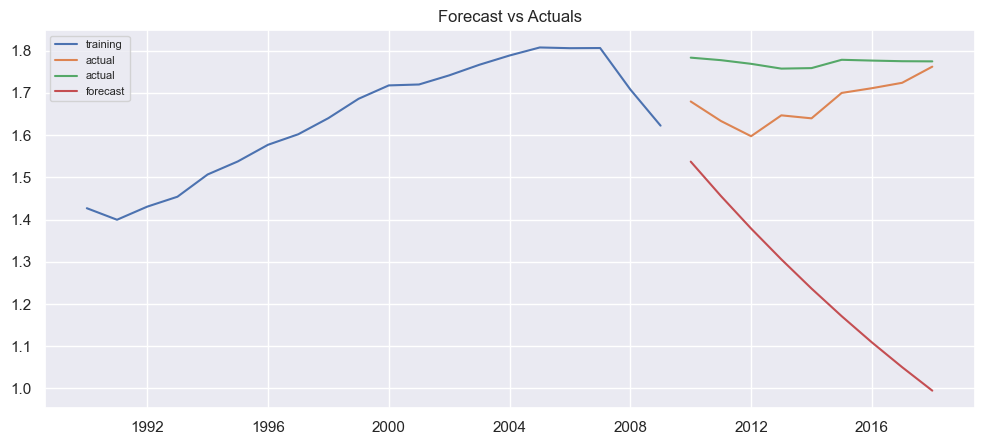

In [380]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Triple Exponential Smoothing or Holt - Winter's Method

**seasonality = additive** , **Trend = additive**

In [381]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["CO2"],seasonal="add",trend="add",seasonal_periods=2,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = start,end = end)

In [382]:
ns_tes_add_add_acc = forecast_accuracy(pred_hwe_add_add,test.CO2)
ns_tes_add_add_acc

{'mape': 0.26308482124948246,
 'me': -0.44628601902384735,
 'mae': 0.44628601902384735,
 'mpe': -0.26308482124948246,
 'rmse': 0.4989470605013598}

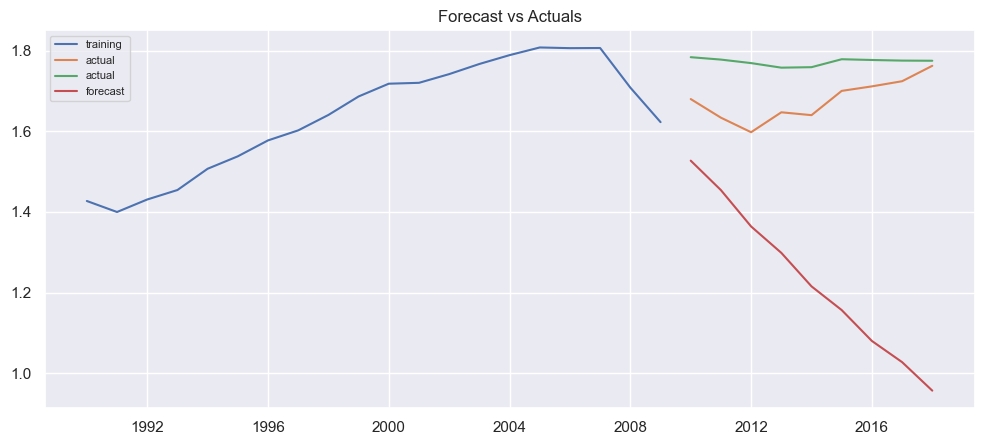

In [383]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_add_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative** , **Trend = additive**

In [384]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="add",seasonal_periods=2).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = start,end = end)

In [385]:
ns_tes_mul_add_acc = forecast_accuracy(pred_hwe_mul_add,test.CO2)
ns_tes_mul_add_acc

{'mape': 0.305681146754328,
 'me': -0.5190171258785163,
 'mae': 0.5190171258785163,
 'mpe': -0.305681146754328,
 'rmse': 0.5886221348869628}

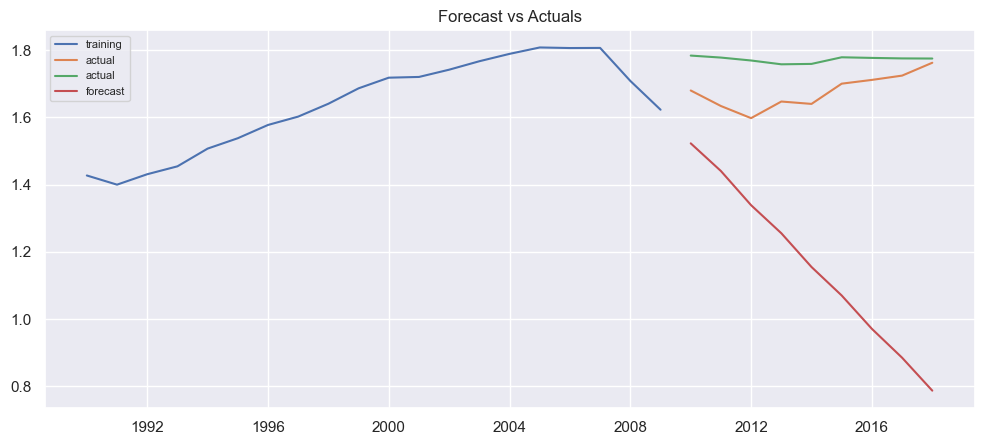

In [386]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative , Trend = multiplicative**

In [387]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_mul = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="mul",seasonal_periods=2).fit()
pred_hwe_mul_mul = hwe_model_mul_add.predict(start = start,end = end)

In [388]:
ns_tes_mul_mul_acc = forecast_accuracy(pred_hwe_mul_mul,test.CO2)
ns_tes_mul_mul_acc

{'mape': 0.305681146754328,
 'me': -0.5190171258785163,
 'mae': 0.5190171258785163,
 'mpe': -0.305681146754328,
 'rmse': 0.5886221348869628}

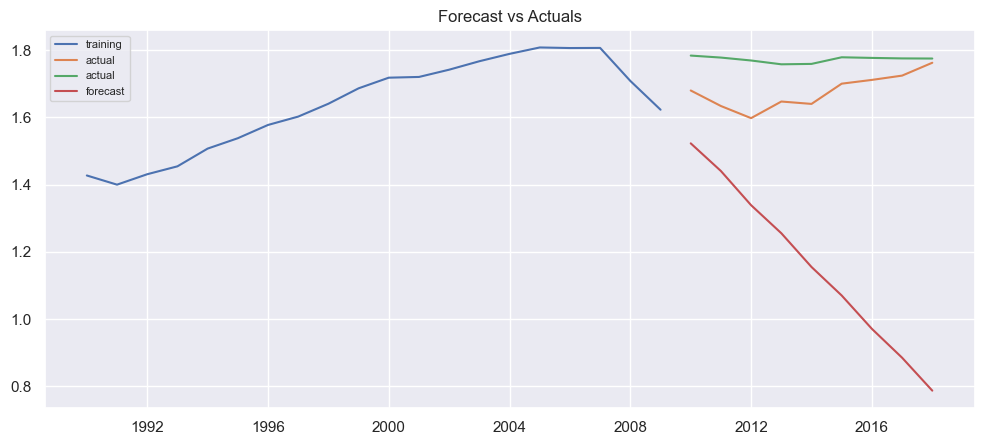

In [389]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_mul, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## LSTM using RNN

In [390]:
scaler = MinMaxScaler()

In [392]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

ValueError: X has 2 features, but MinMaxScaler is expecting 1 features as input.

In [393]:
scaled_train[:10]

array([[0.06690357],
       [0.        ],
       [0.07594658],
       [0.13361108],
       [0.26278642],
       [0.33841441],
       [0.43504472],
       [0.49616469],
       [0.58985418],
       [0.70214435]])

In [ ]:
#define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [ ]:
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'predict this y: \n {y}')

given the array: 
[0.06690357 0.         0.07594658 0.13361108 0.26278642]
predict this y: 
 [[0.33841441]]


In [ ]:
X.shape

(1, 5, 1)

In [ ]:
#define model
model = Sequential()
model.add(LSTM(60, activation = 'relu',return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 60)             14880     
                                                                 
 dropout_4 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 60)             29040     
                                                                 
 dropout_5 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 60)             29040     
                                                                 
 dropout_6 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_7 (LSTM)               (None, 60)               

In [ ]:
#fit model
model.fit(generator,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
15/15 [==============================] - 4s 5ms/step - loss: 0.5403
Epoch 2/50
15/15 [==============================] - 0s 5ms/step - loss: 0.3244
Epoch 3/50
15/15 [==============================] - 0s 6ms/step - loss: 0.1384
Epoch 4/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0501
Epoch 5/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0487
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0382
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0380
Epoch 9/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0412
Epoch 10/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0794
Epoch 11/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0544
Epoch 12/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0454
Epoch 13/50
15/15 [==============================

Text(0.5, 1.0, 'Loss per Epochs')

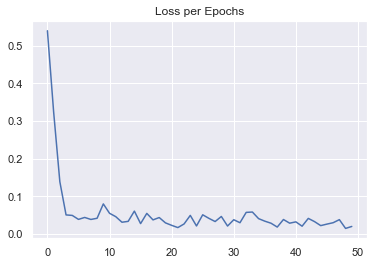

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss per Epochs')

In [ ]:
last_train_batch = scaled_train[-5:]

In [ ]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)

In [ ]:
model.predict(last_train_batch)

array([[0.9408714]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.68643549])

In [ ]:
test_predictions =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

In [ ]:
test_predictions

[array([0.9408714], dtype=float32),
 array([0.9263102], dtype=float32),
 array([0.9050042], dtype=float32),
 array([0.87724537], dtype=float32),
 array([0.8801712], dtype=float32),
 array([0.9284658], dtype=float32),
 array([0.9238911], dtype=float32),
 array([0.920199], dtype=float32),
 array([0.919322], dtype=float32)]

In [ ]:
test.head()

,CO2
Year,
2010-01-01,1.67977
2011-01-01,1.63359
2012-01-01,1.59753
2013-01-01,1.64694
2014-01-01,1.63985


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='Year'>

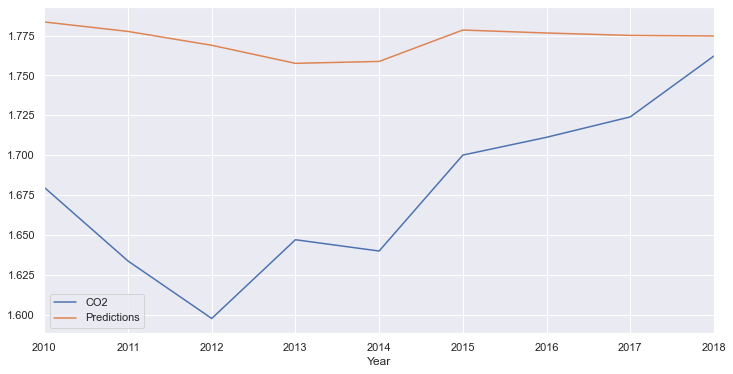

In [ ]:
test.plot(figsize=(12,6))

In [ ]:
ns_lstm_acc = forecast_accuracy(test['Predictions'],test.CO2)
ns_lstm_acc

{'mape': 0.05758433482845953,
 'me': 0.09517722401764682,
 'mae': 0.09517722401764682,
 'mpe': 0.05758433482845953,
 'rmse': 0.1056943887089282}

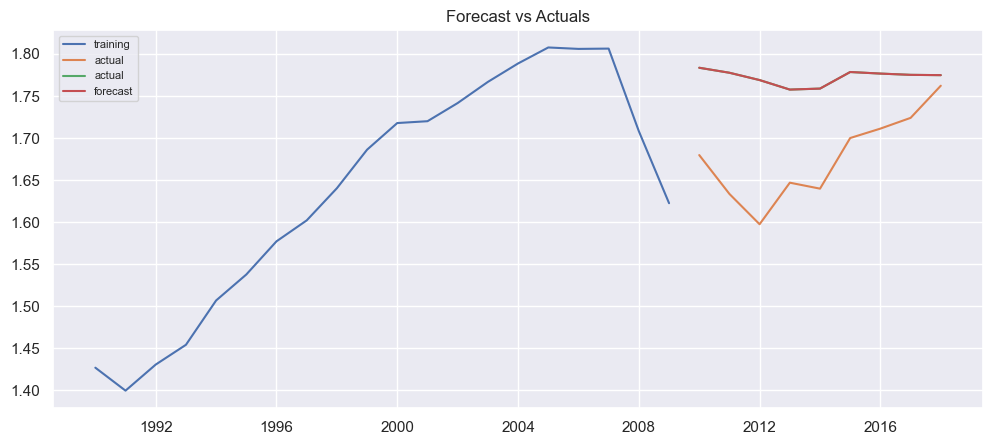

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(test['Predictions'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Forecasting Accuracy

In [ ]:
data = {"MODEL":pd.Series(["ARIMA(3,1,4)","Auto Regressor","single exponential smoothing","Double exponential smoothing","Triple exponential smoothing(additive seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & multiplicative trend)","LSTM(RNN)"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],ns_ar_acc["rmse"],ns_ses_acc["rmse"],ns_des_acc["rmse"],ns_tes_add_add_acc["rmse"],ns_tes_mul_add_acc["rmse"],ns_tes_mul_mul_acc["rmse"],ns_lstm_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],ns_ar_acc["mape"],ns_ses_acc["mape"],ns_des_acc["mape"],ns_tes_add_add_acc["mape"],ns_tes_mul_add_acc["mape"],ns_tes_mul_mul_acc["mape"],ns_lstm_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],ns_ar_acc["me"],ns_ses_acc["me"],ns_des_acc["me"],ns_tes_add_add_acc["me"],ns_tes_mul_add_acc["me"],ns_tes_mul_mul_acc["me"],ns_lstm_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],ns_ar_acc["mae"],ns_ses_acc["mae"],ns_des_acc["mae"],ns_tes_add_add_acc["mae"],ns_tes_mul_add_acc["mae"],ns_tes_mul_mul_acc["mae"],ns_lstm_acc["mae"]]),
"MPE_values":pd.Series([ns_arima_acc["mpe"],ns_ar_acc["mpe"],ns_ses_acc["mpe"],ns_des_acc["mpe"],ns_tes_add_add_acc["mpe"],ns_tes_mul_add_acc["mpe"],ns_tes_mul_mul_acc["mpe"],ns_lstm_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values,MPE_values
1,Auto Regressor,0.053509,0.026506,-0.008956,0.044653,-0.004489
2,single exponential smoothing,0.063103,0.031161,0.039677,0.051325,0.024531
0,"ARIMA(3,1,4)",0.073480,0.035264,-0.054696,0.060256,-0.031783
7,LSTM(RNN),0.105694,0.057584,0.095177,0.095177,0.057584
3,Double exponential smoothing,0.478781,0.252486,-0.428305,0.428305,-0.252486
4,Triple exponential smoothing(additive seasonal...,0.498947,0.263085,-0.446286,0.446286,-0.263085
5,Triple exponential smoothing(multiplicative se...,0.588622,0.305681,-0.519017,0.519017,-0.305681
6,Triple exponential smoothing(multiplicative se...,0.588622,0.305681,-0.519017,0.519017,-0.305681


# Final Model

We have selected **Auto Regressor** as our final model beacuse of following reasons:
- least MAPE & MAE value
- Forecasted values vs Actual values graphs capturing more information when compared to other models

In [394]:
# final_arima = ARIMA(df['CO2'],order = (1,0,1))
# final_arima = final_arima.fit()
# final_arima.summary()
final_ar = AutoReg(df['CO2'],lags=6).fit()
print(final_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   29
Model:                     AutoReg(6)   Log Likelihood                  47.360
Method:               Conditional MLE   S.D. of innovations              0.031
Date:                Sun, 10 Apr 2022   AIC                            -78.719
Time:                        18:22:59   BIC                            -69.635
Sample:                    01-01-1996   HQIC                           -76.435
                         - 01-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4530      0.154      2.942      0.003       0.151       0.755
CO2.L1         0.9638      0.199      4.847      0.000       0.574       1.354
CO2.L2        -0.2710      0.272     -0.995      0.3

In [395]:
final_ar.fittedvalues.tail()

Year
2014-01-01    1.629563
2015-01-01    1.654888
2016-01-01    1.730742
2017-01-01    1.691278
2018-01-01    1.756046
dtype: float64

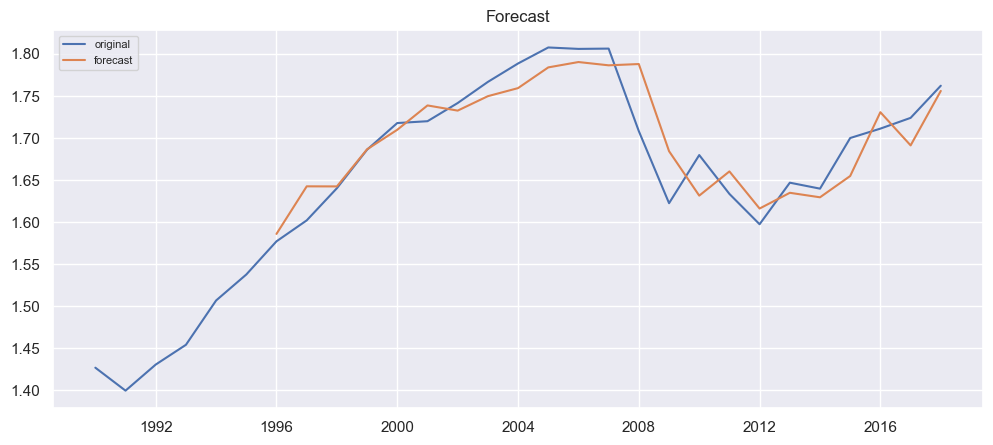

In [397]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_ar.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### creating dataframe for future forecasting

In [398]:
future_dates=[df.index[-1]+ DateOffset(years=x)for x in range(0,6)]

In [399]:
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [400]:
future_df.tail()

,CO2
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN


In [401]:
len(future_df)

5

### Forecasting for  next 5 years using Final ARIMA model

In [402]:
future_df['CO2'] = final_ar.predict(start = 29, end = 34, dynamic= True)  
#future_df[['CO2', 'forecast']].plot(figsize=(12, 8))
#plt.title('Forecast for next 5 years')

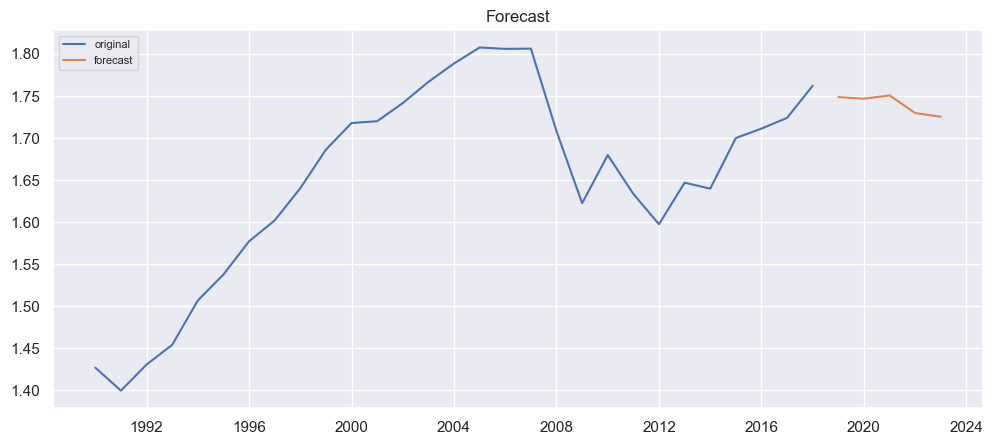

In [403]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [404]:
df.tail()

,CO2
Year,
2014-01-01,1.63985
2015-01-01,1.70005
2016-01-01,1.71122
2017-01-01,1.72402
2018-01-01,1.76224


In [405]:
future_df.tail()

,CO2
2019-01-01,1.748730
2020-01-01,1.746743
2021-01-01,1.750755
2022-01-01,1.729713
2023-01-01,1.725367


In [ ]:
# Exporting to csv file
future_df.to_csv(r'forecast_data_5years.csv',index=True)

## Forecast for 10 years

In [406]:
future_dates_10=[df.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=df.columns)
future_df_10.tail()
len(future_df_10)

10

In [410]:
future_df_10['CO2'] = final_ar.predict(start = 29, end = 39, dynamic= True) 

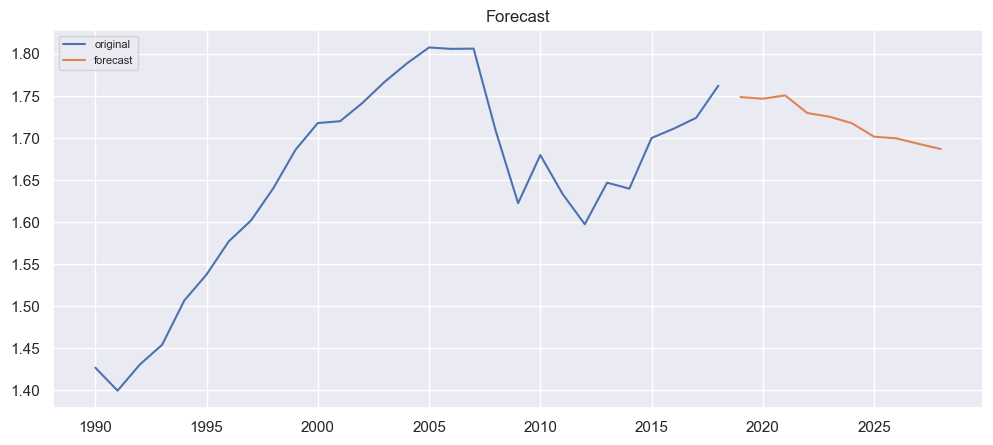

In [411]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
future_df_10

,CO2
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN
2025-01-01,NaN
2026-01-01,NaN
2027-01-01,NaN
2028-01-01,NaN


In [ ]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_10years.csv',index=True)

In [ ]:
# Saving the pickle file
import pickle
pickle.dump(final_ar, open('Forecast_arima.pkl','wb'))